# Exercise 3 Parity

## Imports

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from perceptron import MultiLayerPerceptron
from optimizer import SGD_Optimizer, MomentumOptimizer, AdamOptimiser
import pandas as pd
from collections import defaultdict

## Configuration

### Parameters

In [14]:
# Network architecture & activation
layer_sizes   = [35, 16, 1]
activations   = ['tanh', 'sigmoid']

# Optimizer settings
learning_rate = 0.1
batch_size    = 10    
epochs        = 1000

# Verbosity / logging
verbose       = True
shuffle       = False
loss_kind     = 'cross_entropy'
runs_per_config = 5

### Load Data

In [15]:
with open("../data/TP3-ej3-digitos.txt") as f:
    lines = [line.strip() for line in f if line.strip()]


blocks = [lines[i:i+7] for i in range(0, len(lines), 7)]


X = np.array([
    [int(bit) for row in block for bit in row.split()]
    for block in blocks
])

digits = np.arange(len(blocks))
y01 = (digits % 2).reshape(-1, 1)

## Basic Test

In [31]:
basic_records = []
basic_loss_histories = np.zeros((runs_per_config, epochs))
basic_acc_histories  = np.zeros((runs_per_config, epochs))
mlp = None

for run in range(runs_per_config):
    np.random.seed(run)
    mlp = MultiLayerPerceptron(
        layer_sizes=layer_sizes,
        activations=activations,
        optimizer=SGD_Optimizer(learning_rate),
        learning_rate=learning_rate,
        batch_size=batch_size,
        shuffle=shuffle,
        loss_kind='cross_entropy',
        verbose=verbose
    )
    mlp.fit(X, y01, epochs=epochs)
    basic_records.append({
        'Run': run+1,
        'Final Loss': mlp.losses[-1],
        'Final Accuracy': mlp.accuracies[-1]
    })
    basic_loss_histories[run] = mlp.losses
    basic_acc_histories[run]  = mlp.accuracies

probs = mlp.predict_proba_batch(X).ravel()
preds = (probs >= 0.5).astype(int)
acc = (preds.reshape(-1, 1) == y01).mean()
print(f"\nParity detection accuracy: {acc*100:.1f}%\n")
df = pd.DataFrame({
    'Digit':     digits,
    'Probability(odd)': probs,
    'Prediction': ['odd'  if p else 'even' for p in preds],
    'Actual':     ['odd'  if d%2 else 'even' for d in digits]
})

df

Epoch 1000 — loss: 0.0034, acc: 1.000
Epoch 1000 — loss: 0.0031, acc: 1.000
Epoch 1000 — loss: 0.0032, acc: 1.000
Epoch 1000 — loss: 0.0036, acc: 1.000
Epoch 1000 — loss: 0.0030, acc: 1.000

Parity detection accuracy: 100.0%



,Digit,Probability(odd),Prediction,Actual
0,0,0.002974,even,even
1,1,0.998996,odd,odd
2,2,0.003770,even,even
3,3,0.993095,odd,odd
4,4,0.000360,even,even
5,5,0.998743,odd,odd
6,6,0.000865,even,even
7,7,0.999011,odd,odd
8,8,0.006540,even,even
9,9,0.995210,odd,odd


### Plots

#### Raw Data

In [17]:
df_basic = pd.DataFrame(basic_records)
mean_loss_basic = basic_loss_histories.mean(axis=0)
std_loss  = basic_loss_histories.std(axis=0)
mean_acc  = basic_acc_histories.mean(axis=0)
std_acc   = basic_acc_histories.std(axis=0)
epochs_axis = np.arange(1, epochs+1)
df_basic

,Run,Final Loss,Final Accuracy
0,1,0.003447,1.0
1,2,0.003074,1.0
2,3,0.003249,1.0
3,4,0.003635,1.0
4,5,0.002952,1.0


#### Loss plot

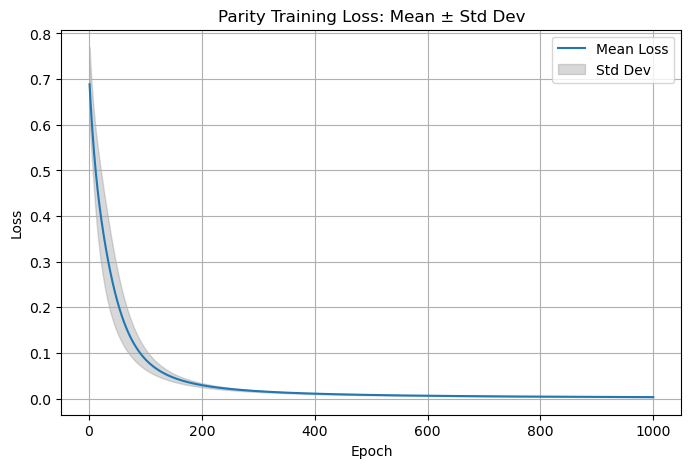

In [18]:
plt.figure(figsize=(8,5))
plt.plot(epochs_axis, mean_loss_basic, label='Mean Loss')
plt.fill_between(
    epochs_axis,
    mean_loss_basic - std_loss,
    mean_loss_basic + std_loss,
    color='gray', alpha=0.3,
    label='Std Dev'
)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Parity Training Loss: Mean ± Std Dev')
plt.legend()
plt.grid(True)
plt.show()

#### Accuracy Plot

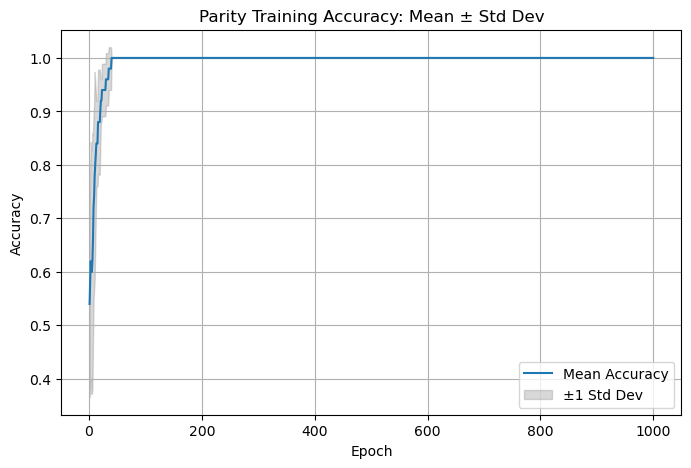

In [19]:
plt.figure(figsize=(8,5))
plt.plot(epochs_axis, mean_acc, label='Mean Accuracy')
plt.fill_between(
    epochs_axis,
    mean_acc - std_acc,
    mean_acc + std_acc,
    color='gray', alpha=0.3,
    label='±1 Std Dev'
)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Parity Training Accuracy: Mean ± Std Dev')
plt.legend()
plt.grid(True)
plt.show()

### Conclusion


## Testing on different Optimizers

### Configurations

In [20]:
learning_rates = [0.001, 0.01, 0.1, 0.5]
optimizers     = {'SGD': SGD_Optimizer, 'Momentum': MomentumOptimizer, 'Adam': AdamOptimiser}
epochs         = 1000
batch_size     = 10

### Gradient Descent

In [21]:
sgd_loss_curves = {}
sgd_acc_curves  = {}
sgd_raw_loss, sgd_raw_acc = {}, {}


for lr in learning_rates:
    L = np.zeros((runs_per_config, epochs))
    A = np.zeros((runs_per_config, epochs))
    for run in range(runs_per_config):
        np.random.seed(run)
        opt = SGD_Optimizer(lr)
        mlp = MultiLayerPerceptron(
            layer_sizes=layer_sizes,
            activations=activations,
            optimizer=opt,
            learning_rate=lr,
            batch_size=batch_size,
            shuffle=False,
            loss_kind='cross_entropy',
            verbose=False
        )
        mlp.fit(X, y01, epochs=epochs)
        L[run] = mlp.losses
        A[run] = mlp.accuracies


    sgd_raw_loss[f"lr={lr}"] = L
    sgd_raw_acc[f"lr={lr}"] = A

    sgd_loss_curves[f"lr={lr}"] = L.mean(axis=0)
    sgd_acc_curves [f"lr={lr}"] = A.mean(axis=0)

iters = np.arange(1, epochs+1)

sgd_loss_std = {label: runs.std(axis=0)
                  for label, runs in sgd_raw_loss.items()}
sgd_acc_std  = {label: runs.std(axis=0)
                  for label, runs in sgd_raw_acc.items()}

#### Accuracy Plot

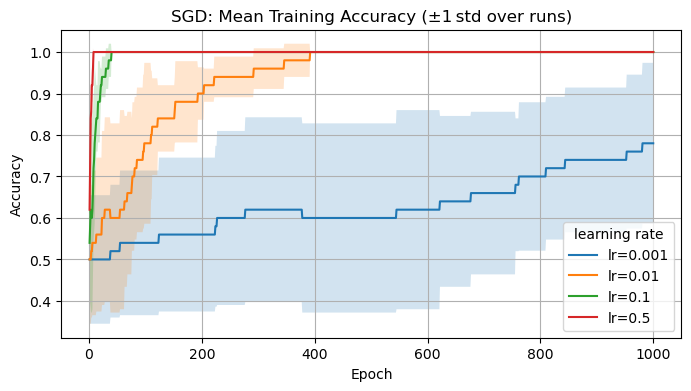

In [22]:
plt.figure(figsize=(8,4))
for label, mean_curve in sgd_acc_curves.items():
    std_curve = sgd_acc_std[label]
    plt.plot(iters, mean_curve, label=label)
    plt.fill_between(iters,
                     mean_curve - std_curve,
                     mean_curve + std_curve,
                     alpha=0.2)
plt.title("SGD: Mean Training Accuracy (±1 std over runs)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(title="learning rate")
plt.grid(True)
plt.show()

#### Loss Plot

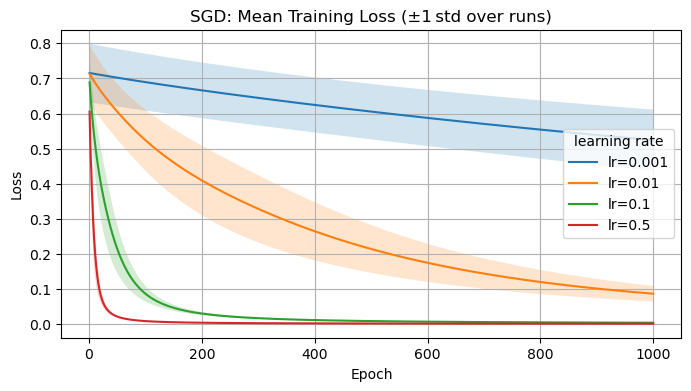

In [23]:
plt.figure(figsize=(8,4))
for label, mean_curve in sgd_loss_curves.items():
    std_curve = sgd_loss_std[label]
    plt.plot(iters, mean_curve, label=label)
    plt.fill_between(iters,
                     mean_curve - std_curve,
                     mean_curve + std_curve,
                     alpha=0.2)
plt.title("SGD: Mean Training Loss (±1 std over runs)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(title="learning rate")
plt.grid(True)
plt.show()

### Momentum

In [24]:
mom_loss_curves = {}
mom_acc_curves  = {}
mom_raw_losses  = {}
mom_raw_accs    = {}

betas = [0.5, 0.9, 0.99]    # good idea to sweep these too!

for beta in betas:
    for lr in learning_rates:
        L = np.zeros((runs_per_config, epochs))
        A = np.zeros((runs_per_config, epochs))
        for run in range(runs_per_config):
            np.random.seed(run)
            # instantiate two momentum optimizers (weights + biases)
            opt = MomentumOptimizer(lr, beta=beta)

            mlp = MultiLayerPerceptron(
                layer_sizes=layer_sizes,
                activations=activations,
                optimizer=opt,
                learning_rate=lr,
                batch_size=batch_size,
                shuffle=False,
                loss_kind='cross_entropy',
                verbose=False
            )
            mlp.fit(X, y01, epochs=epochs)
            L[run] = mlp.losses
            A[run] = mlp.accuracies

        key = f"β={beta}, lr={lr}"
        # store raw histories
        mom_raw_losses[key] = L
        mom_raw_accs  [key] = A
        # compute mean curves
        mom_loss_curves[key] = L.mean(axis=0)
        mom_acc_curves [key] = A.mean(axis=0)

iters = np.arange(1, epochs+1)

# compute per‐epoch std‐dev
mom_loss_std = {k: v.std(axis=0) for k,v in mom_raw_losses.items()}
mom_acc_std  = {k: v.std(axis=0) for k,v in mom_raw_accs.items()}

#### Accuracy Plot

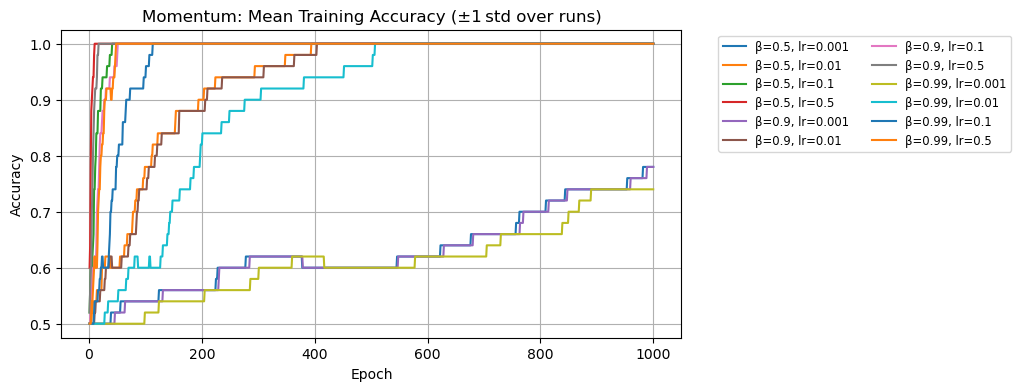

In [25]:
plt.figure(figsize=(8,4))
for label, mean_curve in mom_acc_curves.items():
    std_curve = mom_acc_std[label]
    plt.plot(iters, mean_curve, label=label)
    # plt.fill_between(iters,
    #                  mean_curve-std_curve,
    #                  mean_curve+std_curve,
    #                  alpha=0.2)
plt.title("Momentum: Mean Training Accuracy (±1 std over runs)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(fontsize='small', ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

#### Loss Plot

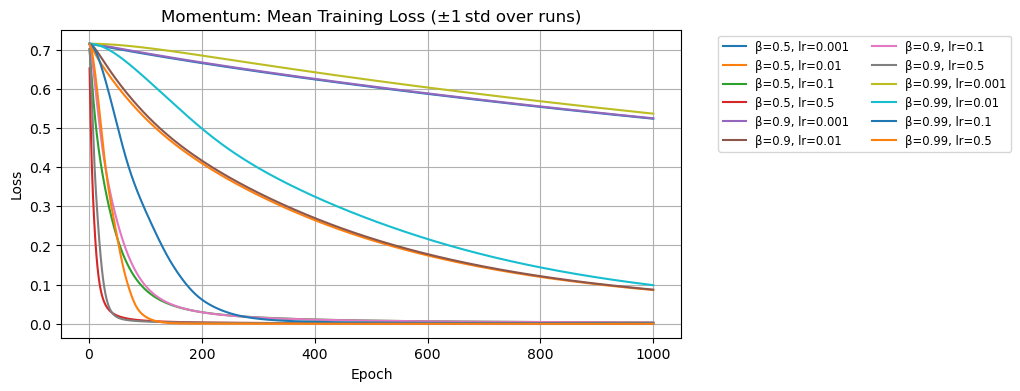

In [26]:
plt.figure(figsize=(8,4))
for label, mean_curve in mom_loss_curves.items():
    std_curve = mom_loss_std[label]
    plt.plot(iters, mean_curve, label=label)
    # plt.fill_between(iters,
    #                  mean_curve-std_curve,
    #                  mean_curve+std_curve,
    #                  alpha=0.2)
plt.title("Momentum: Mean Training Loss (±1 std over runs)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(fontsize='small', ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

### Adam

In [27]:
learning_rates = [0.001, 0.01, 0.1]
beta1_vals     = [0.9, 0.99]
beta2_vals     = [0.999, 0.9999]
epsilons       = [1e-8, 1e-6]

adam_raw_losses = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
adam_raw_accs   = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
adam_loss_curves = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
adam_acc_curves  = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
adam_loss_std    = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
adam_acc_std     = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for lr in learning_rates:
    for b1 in beta1_vals:
        for b2 in beta2_vals:
            for eps in epsilons:
                L = np.zeros((runs_per_config, epochs))
                A = np.zeros((runs_per_config, epochs))
                for run in range(runs_per_config):
                    np.random.seed(run)
                    opt = AdamOptimiser(lr, beta1=b1, beta2=b2, epsilon=eps)
                    mlp = MultiLayerPerceptron(
                        layer_sizes   =layer_sizes,
                        activations   =activations,
                        optimizer     =opt,
                        learning_rate =lr,
                        batch_size    =batch_size,
                        shuffle       =False,
                        loss_kind     ='cross_entropy',
                        verbose       =False
                    )
                    mlp.fit(X, y01, epochs=epochs)
                    L[run] = mlp.losses
                    A[run] = mlp.accuracies

                adam_raw_losses[lr][b1][b2][eps] = L
                adam_raw_accs  [lr][b1][b2][eps] = A
                adam_loss_curves[lr][b1][b2][eps] = L.mean(axis=0)
                adam_acc_curves [lr][b1][b2][eps] = A.mean(axis=0)
                adam_loss_std   [lr][b1][b2][eps] = L.std(axis=0)
                adam_acc_std    [lr][b1][b2][eps] = A.std(axis=0)

iters = np.arange(1, epochs+1)

def plot_aggregates(agg_mean, agg_std, param_name, ylabel, title):
    plt.figure(figsize=(8,4))
    for key, mean_curve in agg_mean.items():
        std_curve = agg_std[key]
        plt.plot(iters, mean_curve, label=f"{param_name}={key}")
        plt.fill_between(iters,
                         mean_curve - std_curve,
                         mean_curve + std_curve,
                         alpha=0.2)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.show()

def aggregate_and_plot(param_name, param_values):
    agg_loss, agg_std_loss = {}, {}
    agg_acc,  agg_std_acc  = {}, {}
    for v in param_values:
        loss_list, acc_list = [], []
        for lr in learning_rates:
            for b1 in beta1_vals:
                for b2 in beta2_vals:
                    for eps in epsilons:
                        if param_name=="lr"    and lr  != v: continue
                        if param_name=="beta1" and b1  != v: continue
                        if param_name=="beta2" and b2  != v: continue
                        if param_name=="eps"   and eps != v: continue
                        loss_list.append(adam_loss_curves[lr][b1][b2][eps])
                        acc_list. append(adam_acc_curves [lr][b1][b2][eps])
        L = np.stack(loss_list); A = np.stack(acc_list)
        agg_loss[v]     = L.mean(axis=0)
        agg_std_loss[v] = L.std (axis=0)
        agg_acc [v]     = A.mean(axis=0)
        agg_std_acc[v]  = A.std (axis=0)

    plot_aggregates(agg_loss,    agg_std_loss,
                    param_name, "Loss",
                    f"Adam Loss aggregated over others per {param_name}")
    plot_aggregates(agg_acc,     agg_std_acc,
                    param_name, "Accuracy",
                    f"Adam Accuracy aggregated over others per {param_name}")

#### Aggregate Per Learning Rate

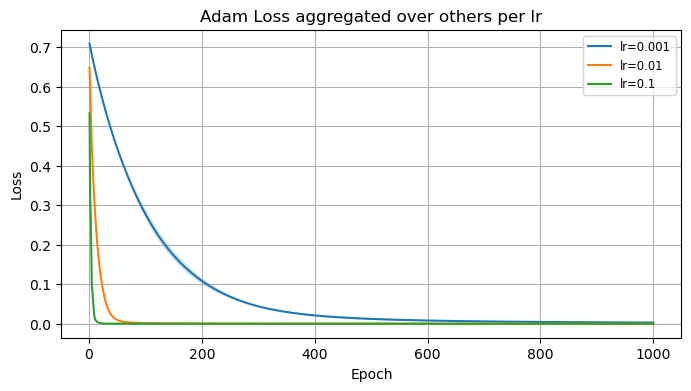

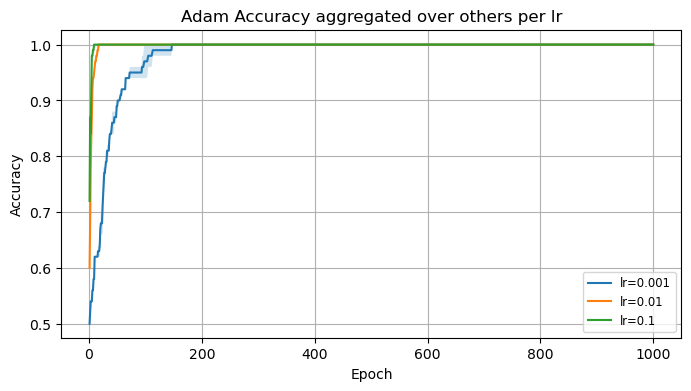

In [28]:
aggregate_and_plot("lr", learning_rates)

#### Aggregate Per Beta1

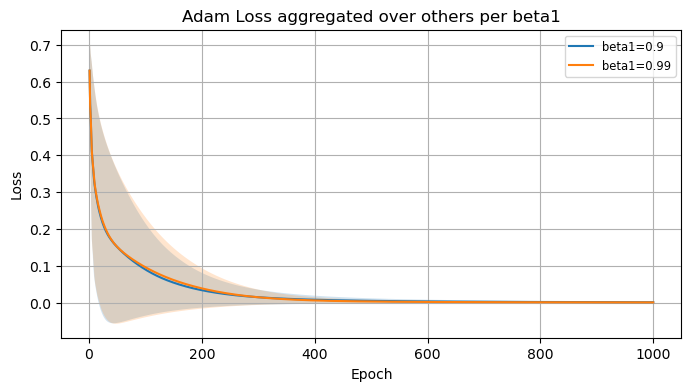

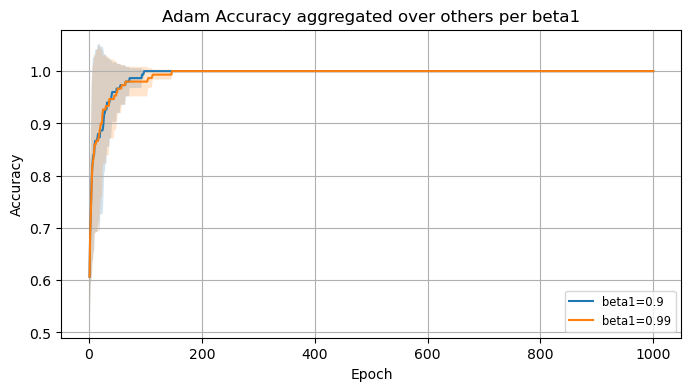

In [29]:
aggregate_and_plot("beta1",  beta1_vals)


#### Aggregate Per Beta2

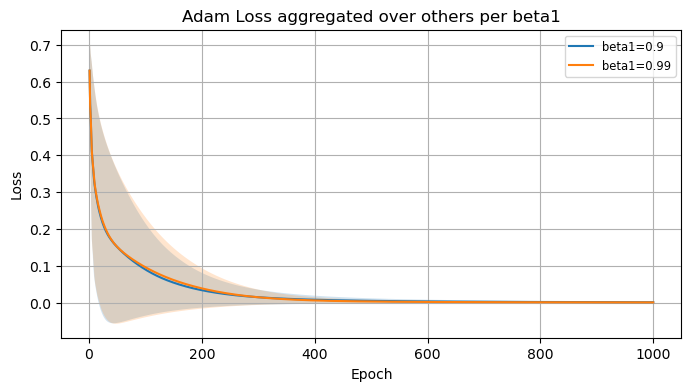

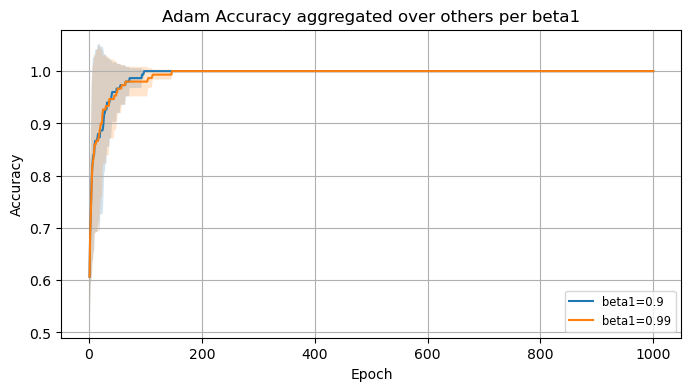

In [30]:
aggregate_and_plot("beta1",  beta1_vals)
